In [5]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation
from models import *

In [6]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)

df_MHNatChem = exp_data.clip(lower=0)

In [50]:
params = [24.30616411,  1.1391591,   3.08829181, 10.66927823]
consts = [0.17, 4]
init_cond = [0.1, 0]
osc_MHNatChem = oscillation(approx_model_FTC, params, consts, init_cond, calc_all_approx_model_FTC)
osc_MHNatChem.add_exp_data(df_MHNatChem)
osc_MHNatChem.add_info('Chemical oscillation in the Nature Chemistry paper, Michael Howlett, 3b')

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [60]:
osc_MHNatChem.interactive_plot(exp=True, ran=20)

interactive(children=(FloatSlider(value=24.30616411, description='alpha', max=44.30616411, min=4.3061641100000…

(<Figure size 700x500 with 4 Axes>,
 <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>)

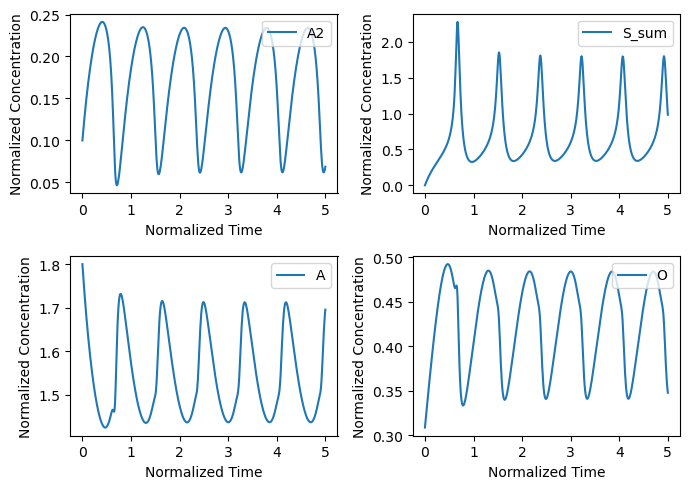

In [9]:
osc_MHNatChem.plot(t=5)

In [ ]:
def rate_approx_model_FTC(vars, params, target=['S']):
    alpha, beta, theta, phi, lam, m = params
    cA2, cS = vars
    if 'S' in target:
        Sform_c = alpha/lam * cA2 * cS**m
        Sform_nc = theta/lam * cA2
        Sdecomp_c = beta * cS**(m + 1) 
        Sdecomp_nc = phi * cS
    
    #The changing rate of A2 can be added here if needed.
    
    return Sform_c, Sform_nc, Sdecomp_c, Sdecomp_nc

In [64]:
sol = osc_MHNatChem.simulate(t=3)

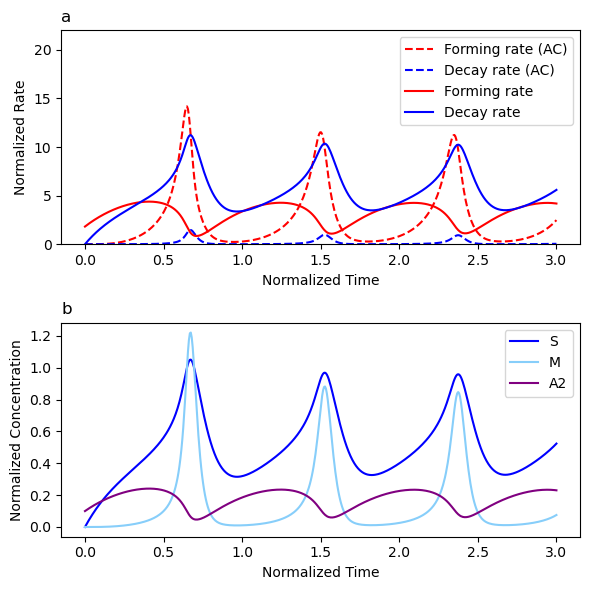

In [75]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax1, ax2 = ax
sfc, sfnc, sdc, sdnc = rate_approx_model_FTC(sol.y, params+consts)
ax1.plot(sol.t, sfc, label='Forming rate (AC)', linestyle='--', color='r')
ax1.plot(sol.t, sdc, label='Decay rate (AC)', linestyle='--', color='b')
ax1.plot(sol.t, sfnc, label='Forming rate', color='r')
ax1.plot(sol.t, sdnc, label='Decay rate', color='b')
ax1.set_xlabel('Normalized Time')
ax1.set_ylabel('Normalized Rate')
ax1.set_title('a', loc='left')
ax1.set_ylim(0, 22)

ax2.plot(sol.t, sol.y[1], label='S', color='b')
ax2.plot(sol.t, sol.y[1]**4, label='M', color='lightskyblue')
ax2.plot(sol.t, sol.y[0], label='A2', color='purple')
ax2.set_xlabel('Normalized Time')
ax2.set_ylabel('Normalized Concentration')
ax2.set_title('b', loc='left')

ax1.legend(loc=1)
ax2.legend(loc=1)

plt.tight_layout()